# Анализ поведения пользователей мобильного приложения <br> для покупки продуктов питания

## 1. Обзор данных

**Импорты**

In [1]:
import pandas as pd
import datetime
import math

from plotly import graph_objects as go
import plotly.express as px

from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

import plotly.io as pio
pio.renderers.default = "png"

**Апдейты**

In [2]:
#!pip install plotly --upgrade --user

**Таблицы**

In [3]:
df = pd.read_csv('logs_exp.csv', sep='\t')

**Обзор**

In [4]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**На предобработку:**
- Названия столбцов
- Столбец с датой в datetime
- Значения в категориальных столбцах (EventName, ExpId)
- Дубликаты

## 2. Предобработка

**Названия столбцов**

In [6]:
df.columns = ['event', 'user_id', 'event_datetime', 'exp_group']

**Столбец с датой в дейттайм**

In [7]:
df['event_datetime'] = pd.to_datetime(df['event_datetime'], unit='s')

**Значения в категориальных переменных**

In [8]:
#значения в категориальных столбцах
df['event'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [9]:
df['exp_group'].unique()

array([246, 248, 247], dtype=int64)

Все ок, ничего лишнего

**Дубликаты**

In [10]:
print('Полных дубликатов в таблице:', df.duplicated().sum())

Полных дубликатов в таблице: 413


In [11]:
#удалим
#если уж это события одинаковые с точностью до секунды, 
#то скорее всего они просто задвоились и нам не нужны
df.drop_duplicates(inplace=True)

**Таблица после предобработки**

In [12]:
df.head()

,event,user_id,event_datetime,exp_group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


## 3. Проверка данных

### Гистограмма количества событий на одного пользователя

In [13]:
eventCountByUsers = df.groupby('user_id', as_index=False) \
    .agg({'event':'count'}) \
    .rename(columns={'event':'event_count'})

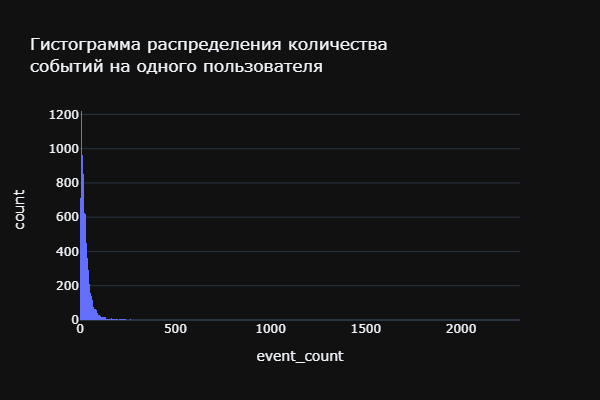

In [14]:
px.histogram(eventCountByUsers, 
             x='event_count',
             title="Гистограмма распределения количества<br>событий на одного пользователя",
             labels={'event_date':''},
             template='plotly_dark',
             width=600, 
             height=400)

У распределения огромный хвост, поэтому для оценки среднего будем брать медиану. 

### Общие данные

In [15]:
print('Всего событий в логе:', df.shape[0])
print('Всего пользователей в логе:', df['user_id'].nunique())
print('Событий на одного пользователя в среднем: {:.0f}'.format(eventCountByUsers['event_count'].median()))

Всего событий в логе: 243713
Всего пользователей в логе: 7551
Событий на одного пользователя в среднем: 20


### Период имеющихся данных

In [16]:
#вытащим дату в отдельный столбец
df['event_date'] = df['event_datetime'].dt.date

In [17]:
print('Самая ранняя дата:', df['event_datetime'].min())
print('Самая поздняя дата:', df['event_datetime'].max())
print('Период имеющихся данных:', df['event_datetime'].max() - df['event_datetime'].min())

Самая ранняя дата: 2019-07-25 04:43:36
Самая поздняя дата: 2019-08-07 21:15:17
Период имеющихся данных: 13 days 16:31:41


Грубо говоря, имеем 14 дней эксперимента. 

### Распределение записей в логах по датам

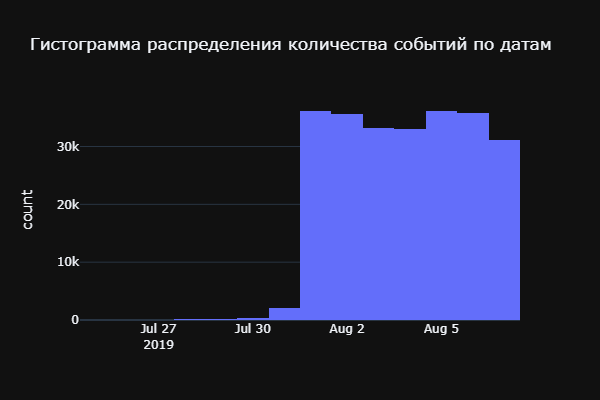

In [18]:
px.histogram(df, 
             x='event_date',
             title="Гистограмма распределения количества событий по датам",
             labels={'event_date':''},
             template='plotly_dark',
             width=600, 
             height=400)

Видим, что полные данные мы начинаем получать только с 1 августа. Сохраним данные начиная с 1 августа в отдельный фрейм. Получается, что **в нашем распоряжении на самом деле всего неделя наблюдений.** 

In [19]:
#оставим в новом фрейме только наблюдения с 1 августа
df_upd = df.query('event_datetime > 20190801')

In [20]:
print('Отбросив часть данных мы потеряли {} пользователей'. format(df['user_id'].nunique() - df_upd['user_id'].nunique()))
print('Это {:.1%} от общего числа пользователей'. format((df['user_id'].nunique() - df_upd['user_id'].nunique()) / df['user_id'].nunique()))

Отбросив часть данных мы потеряли 17 пользователей
Это 0.2% от общего числа пользователей


### Распределение пользователей по группам

In [21]:
df_upd.groupby('exp_group') \
    .agg({'user_id':'nunique'})

,user_id
exp_group,
246,2484
247,2513
248,2537


Все ок! Количество пользователей в группах различается незначительно.

## 4. Изучаем воронку событий

### События в логах

**Общее кол-во событий**

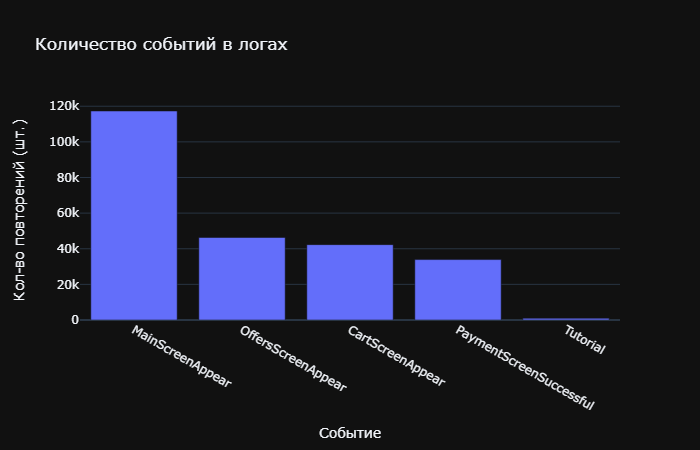

In [22]:
px.bar(df_upd['event'].value_counts().reset_index(), 
       x='index', 
       y='event',
       title='Количество событий в логах',
       labels={'index':'Событие', 'event':'Кол-во повторений (шт.)'},
       template='plotly_dark',
       height=450)

**События и уникальные пользователи**

In [23]:
#найдем кол-во пользователей для каждого из событий
funnel = df.groupby('event', as_index=False)\
    .agg({'user_id':'nunique'})\
    .rename(columns={'user_id':'uniqe_user_count'})\
    .sort_values(by='uniqe_user_count', ascending=False)

In [24]:
#найдем общее количество пользователей в логах
all_users = df_upd['user_id'].nunique()

In [25]:
#найдем для каждого события долю пользователей, которые хоть раз его совершали
funnel['unique_user_rate'] = (funnel['uniqe_user_count'] / all_users).round(2)

In [26]:
funnel.reset_index(drop=True, inplace=True)

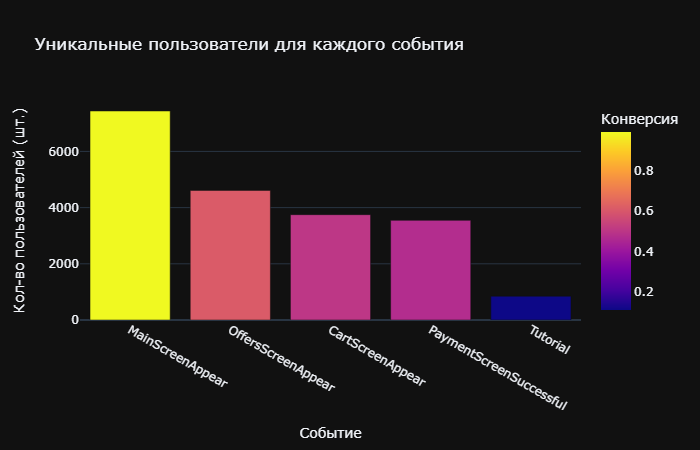

In [27]:
px.bar(funnel, 
       x='event', 
       y='uniqe_user_count',
       color='unique_user_rate',
       title='Уникальные пользователи для каждого события',
       labels={'event':'Событие', 
               'uniqe_user_count':'Кол-во пользователей (шт.)',
               'unique_user_rate':'Конверсия'},
       template='plotly_dark',
       height=450)

### Воронка событий

Судя по названиями и количеству пользователей на каждом этапе, воронка выглядит так:

- MainScreenAppear (Главный экран)
- OffersScreenAppear (Экран с предложением - товаром)
- CartScreenAppear (Экран с корзиной)
- PaymentScreenSuccessful (Экран с подтверждением оплаты)

Этап tutorial по количеству пользователей стоит после подтверждения оплаты, но логически ему там не место. Скорее всего tutorial предлагается пройти на главном экране (или даже перед ним), но этот этап можно скипнуть. Думаю, что его можно не учитывать в итоговой воронке. 

In [28]:
#уберем этап tutorial из воронки
funnel.drop(4, inplace=True)

**Иллюстрируем воронку событий**

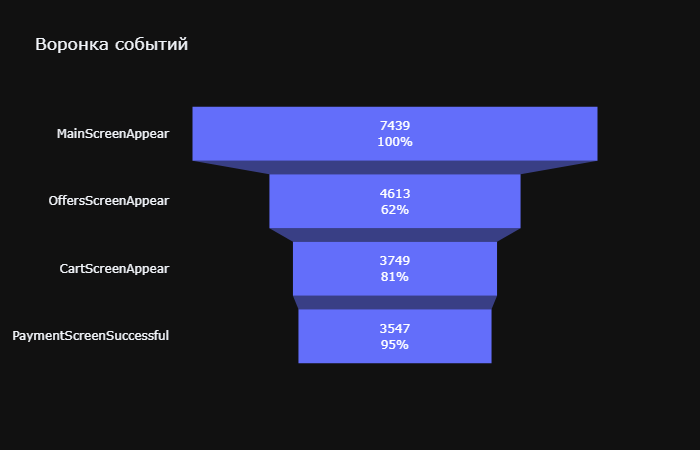

In [29]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    y = funnel['event'],
    x = funnel['uniqe_user_count'],
    textinfo = "value+percent previous"))

fig.update_layout(
    title="Воронка событий",
    template='plotly_dark',
    height=450
)

fig.show()

Для каждого этапа воронки на графике показывается количество пользователей и доля пользователей <u>от числа пользователей на предыдущем этапе.<u/>

**Выводы**

Больше всего пользователей теряется между главным экраном и оффер-скрином

In [30]:
print('От первого события до оплаты доходит {:.1%} пользователей'.format(funnel.loc[3, 'uniqe_user_count'] / funnel.loc[0, 'uniqe_user_count']))

От первого события до оплаты доходит 47.7% пользователей


## 5. Изучаем результаты эксперимента

### Пересечения в группах

In [31]:
print('Количество пользователей, которые попали больше, чем в одну группу: ', df_upd.groupby('user_id', as_index=False) \
    .agg({'exp_group':'nunique'}) \
    .query('exp_group != 1') \
    .shape[0])

#на всякий случай сделал через (не равно единице), вдруг там у кого-то был бы ноль групп, уж не знаю по каким причинам

Количество пользователей, которые попали больше, чем в одну группу:  0


Получается, что все ок: пересечений нет. 

**Достаточно ли пользователей для теста?**

Если мы будем считать, что для нас главная конверсия в этом тесте - это конверсия из мейнскрина (можно грубо сказать, что из всех пользователей группы) в заказ, то при нашем количестве пользователей мы увидим и зафиксируем (как значимый) абсолютный прирост, только если он составит 4% и выше. 

### Функция для проверки различий в группах

В следующих заданиях мы будем проделывать однотипную операцию: проверять статистическую значимость различий конверсии между группами. С этим справится z-тест. **Конверсией в нашем случае будет считаться доля уникальных пользователей группы, которые перешли на выбранный этап вопронки.** Для рассчета конверсии нам нужно знать общее число уникальных пользователей в каждой группе (это число не меняется) и кол-во уникальных пользователей в группе, перешедших на указанный этап воронки (это число меняется в зависимости от этапа). Напишем общую функцию для этой проверки. 

Она будет принимать на вход фрейм и номера групп сравнения, а возвращать - целую таблицу с результатами. В таблице будут конверсии по каждой группе, p_value и результат теста для выбранного уровня значимости. 

**Дисклеймер.** В коде функции будет вагон и маленькая тележка комментариев. Я пишу их скорее для себя, чтобы все это получше уселось в голове. 

In [32]:
#Первый модуль для итоговой функции
#принимает фрейм, группу и название этапа воронки
#возвращает количество уникальных пользователей дошедших до этого этапа в этой группе

def usersOnStepCounter(dataframe, group, step):
    usersOnStepcount = dataframe \
    .query('exp_group == @group & event == @step') \
    ['user_id'].nunique()
    
    return usersOnStepcount

In [33]:
#второй модуль для итоговой функции
#принимает фрейм, группы и название этапа
#возвращает строку с результатами: конверсии, p-значение, результат стат.теста

def difference_test(dataframe, group1, group2, step):
    #объявим словарь для количеств пользователей на каждом шаге и в целом в группе
    usersOnStep = {}
    groupSize = {}
    
    #сохраним количества пользователей дошедших до данного этапа
    #ключ - номер группы
    usersOnStep[group1] = usersOnStepCounter(dataframe, group1, step)
    usersOnStep[group2] = usersOnStepCounter(dataframe, group2, step)
    
    #получим и сохраним размеры групп
    groupSize[group1] = dataframe.query('exp_group == @group1')['user_id'].nunique()
    groupSize[group2] = dataframe.query('exp_group == @group2')['user_id'].nunique()
    
    #теперь посчитаем z-статистику
    #z_value = (p1 - p2) / math.sqrt(P * (1 - P) * (1/n1 + 1/n2) )
    
    #p1 - это конверсия (пропорция) в первой группе
    #p2 - конверсия во второй
    p1 = usersOnStep[group1] / groupSize[group1]
    p2 = usersOnStep[group2] / groupSize[group2]
    
    #P - это конверсия во всем наборе (в первой и второй выборке вместе)
    #причем это не среднее из двух конверсий, а именно конверсия объединенного набора данных
    P = (usersOnStep[group1] + usersOnStep[group2]) \
        / (groupSize[group1] + groupSize[group2])
    
    #n1 и n2 - размеры двух выборок    
    #в числителе формулы есть еще (п1 - п2), но именно равенство этих двух показателей мы и предполагаем
    #поэтому они автоматически исчезают
    
    #считаем z-статистику
    z_value = (p1 - p2) / math.sqrt(P * (1 - P) * (1/groupSize[group1] + 1/groupSize[group2]) )
    
    #теперь найдем p-value для такого z-значения
    
    #задаем нормальное распределение и сохраняем в переменную distr
    distr = st.norm(0,1)
    
    #считаем p-value c помощью кумулятивной функции распределения
    #cdf(x) - кумулятивная функция распрделения
    #она возвращает вероятность того, что некоторая величина примет значение меньшее или равное x
    #образно говоря, она возвращает вероятность получить любое значение... 
    #...в области закрашенного графика распределения до нашего значения x
    #вычитая из неё единицу, мы получим вероятность получить хвост справа
    #нас интересует двусторонее отклонение, то есть не только левый, но и правый хвост
    #поэтому множаем на два
    #а еще - берем z_value по модулю
    #ведь иначе, при вычитани полученного результата из единицы 
    #при отрицательном z_value 
    #мы получим не тот хвост
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    #теперь сравниваем с уровнем значимости, возьмем его 0.05
    alpha = 0.05
    #сохраняем ответ по тесту в отдельную переменную
    if p_value < alpha:
        z_test_message = 'значимы'
    else:
        z_test_message = 'незначимы'
    
    #возвращаем строку с ответом: 
    #конверсия в первой группе 
    #конверсия во второй
    #p_value
    #результат z-теста
    return ['{:.2%}'.format(p1), '{:.2%}'.format(p2), p_value.round(3), z_test_message]

In [34]:
#для итоговой функции нужен список этапов
#сохраних их (без этапа tutorial) в отдельную переменную
events_list = df_upd['event'].unique()[1:5]

In [35]:
#итоговая функция
#принимает фрейм и две группы
#проходит в цикле по каждому событию и записывает результат в список
#а затем создает аккуратный фрейм с результатами
def group_comparison(dataframe, group1, group2):
    results = []
    
    for event in events_list:
        results.append(difference_test(dataframe, group1, group2, event))
        
    columns_names = ['Конверсия ' + str(group1), 'Конверсия ' + str(group2), 'p-значение', 'Различия']

    return pd.DataFrame(data=results, index=events_list, columns=columns_names)

### А/А-тест. Проверяем различия

**Самое популярное событие: показ главного экрана**

Посчитаем число и долю пользователей, совершивших это событие в каждой из контрольных групп.

In [36]:
#найдем число пользователей
mainScreenUsers = df_upd.query('event == "MainScreenAppear"') \
    .groupby('exp_group', as_index=False) \
    .agg({'user_id':'nunique'}) \
    .rename(columns={'user_id':'users_count'})

In [37]:
#найдем размер каждой группы
groupUsersCount = df_upd.groupby('exp_group', as_index=False) \
    .agg({'user_id':'nunique'}) \
    .rename(columns={'user_id':'users_count'})

In [38]:
#поделим на размер групп и получим долю
mainScreenUsers['conversion'] = (mainScreenUsers['users_count'] / groupUsersCount['users_count']).round(3)

In [39]:
mainScreenUsers

,exp_group,users_count,conversion
0,246,2450,0.986
1,247,2476,0.985
2,248,2493,0.983


Конверсия в самый популярный этап между 246 и 247 группами отличается на одну тысячную. 

Теперь давайте проверим все этапы и посмотрим статистическую значимость различий.

**Сравнение контрольных групп: 246 и 247**

In [40]:
group_comparison(df_upd, 246, 247)

,Конверсия 246,Конверсия 247,p-значение,Различия
MainScreenAppear,98.63%,98.53%,0.757,незначимы
OffersScreenAppear,62.08%,60.49%,0.248,незначимы
CartScreenAppear,50.97%,49.26%,0.229,незначимы
PaymentScreenSuccessful,48.31%,46.08%,0.115,незначимы


<u>Вывод: группы настроены корректно.</u> Конверсия различается тем больше, чем дальше по воронке мы продвигаемся. P-значение при этом не подтверждает различия на всех этапах даже на уровне значимости в 0.1 (хотя мы для себя установили 0.05). Скорее всего колебания появляются из-за того, что с каждым этапом уменьшается размер выборок. 

### А/B-тест. Проверяем различия

**Сравнение групп: 246 (А) и 248 (B)**

In [41]:
group_comparison(df_upd, 246, 248)

,Конверсия 246,Конверсия 248,p-значение,Различия
MainScreenAppear,98.63%,98.27%,0.295,незначимы
OffersScreenAppear,62.08%,60.35%,0.208,незначимы
CartScreenAppear,50.97%,48.48%,0.078,незначимы
PaymentScreenSuccessful,48.31%,46.55%,0.212,незначимы


**Сравнение групп: 247 (А) и 248 (B)**

In [42]:
group_comparison(df_upd, 247, 248)

,Конверсия 247,Конверсия 248,p-значение,Различия
MainScreenAppear,98.53%,98.27%,0.459,незначимы
OffersScreenAppear,60.49%,60.35%,0.920,незначимы
CartScreenAppear,49.26%,48.48%,0.579,незначимы
PaymentScreenSuccessful,46.08%,46.55%,0.737,незначимы


Оба A/B-теста не показывают статистически значимых различий (даже на уровне в 0.1). Причем сравнение 247 и 248 вообще говорит о том, что результаты практически идентичные. 

**Сравнение групп: объединённая 246 (А) + 247 (А) и 248 (B)**

In [43]:
#чтобы сделать это сравнение, используя мою функцию, придется сделать еще один фрейм
#в нем мы заменим номера групп: события из групп 246 и 247 получат одинаковый номер - 245
united_control_groups_df = df_upd.replace({'exp_group': [246, 247]}, 245)

In [44]:
group_comparison(united_control_groups_df, 245, 248)

,Конверсия 245,Конверсия 248,p-значение,Различия
MainScreenAppear,98.58%,98.27%,0.294,незначимы
OffersScreenAppear,61.28%,60.35%,0.434,незначимы
CartScreenAppear,50.11%,48.48%,0.182,незначимы
PaymentScreenSuccessful,47.19%,46.55%,0.600,незначимы


В объединенной группе результаты характерным образом не отличаются. 

### A/B-тест. Проверим еще одну гипотезу

Наибольшее кол-во пользователей отваливается между главным экраном и оффер-скрином. Что, если изменение шрифтов повлияло именно на эту конверсию? Проверим эту гипотезу. На этот раз воспользуемся готовой функцией для z-теста.

**Подготовка данных**

In [45]:
#сделаем воронку по всем группам
group_funnel = df_upd.pivot_table(index='event', 
                   columns='exp_group', 
                   values='user_id', 
                   aggfunc='nunique') \
    .sort_values(by=246, ascending=False) \
    .drop('Tutorial')

In [46]:
#напишем функцию, которая принимает два номера групп и печатает все результаты

def mainScreenToOfferConversionComparison(group1, group2):
    #посчитаем кол-во "попыток" - пользователей увидевших главный экран
    prev_step_users = []
    prev_step_users.append(group_funnel.loc["MainScreenAppear",group1])
    prev_step_users.append(group_funnel.loc["MainScreenAppear",group2])

    #посчитаем кол-во "успехов" - пользователей увидевших офферскрин
    next_step_users = []
    next_step_users.append(group_funnel.loc["OffersScreenAppear",group1])
    next_step_users.append(group_funnel.loc["OffersScreenAppear",group2])
    
    print('Конверсия {}: {:.2%}'.format(group1, (next_step_users[0] / prev_step_users[0])))
    print('Конверсия {}: {:.2%}'.format(group2, (next_step_users[1] / prev_step_users[1])))
    print('Z-тест p-value: {:.3f}'.format(proportions_ztest(next_step_users, prev_step_users, alternative='two-sided')[1]))         

**Сравнение конверсий с главного экрана в оффер-скрин: 246 vs 248**

In [47]:
mainScreenToOfferConversionComparison(246, 248)

Конверсия 246: 62.94%
Конверсия 248: 61.41%
Z-тест p-value: 0.268


**Сравнение конверсий с главного экрана в оффер-скрин: 247 vs 248**

In [48]:
mainScreenToOfferConversionComparison(247, 248)

Конверсия 247: 61.39%
Конверсия 248: 61.41%
Z-тест p-value: 0.987


Нет, эта гипотеза тоже не подтвердилась.

## Результаты

**В ходе проекта мы:** разбирались как ведут себя пользователи приложения для заказа продуктов питания и анализировали результаты эксперимента с заменой шрифтов. 

**Результаты проекта**

1. Определили воронку продаж:

- Главный экран
- Экран с предложением - товаром
- Экран с корзиной
- Экран с подтверждением оплаты

2. Высянили, что до покупки доходит 47% пользователей.

3. Больше всего пользователей отваливается между главным экраном и экраном с товаром.

4. Эксперимент со шрифтами неудачный. Конверсия на разных этапах значимо не изменилась. 

5. Конверсия из главного экрана в экран с товарами тоже значимо не изменилась в группе с новыми шрифтами. 

**Вывод-рекомендация:** стоит оставить имеющийся шрифт. 